# Klarna Case Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge


## Data Retrieval

In [2]:
def get_col_info():
    colInfo = 'CaseStudyCols.csv'

    with open(colInfo, newline='') as csv_file:
        reader = csv.reader(csv_file, delimiter=';')
        # skip over the first row
        reader.__next__()
        rows = list(reader)

    col_names_types = {row[0]: row[1] for row in rows}

    return col_names_types


In [3]:
dataSet = 'dataset.csv'

"""
Note that in reality the column 'default' and
'worst_status_active_inv' as actually ints, but
since they have NA values, we load them as objects
for now.

But note that the entries where default = NA are actually our
entries that we are supposed to predict (validate set?)
"""

df = pd.read_csv(dataSet, delimiter=';', dtype = get_col_info(), keep_default_na=True)

Data Processing & Wrangling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  object 
 2   account_amount_added_12_24m          99976 non-null  int32  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

In [5]:
# Strip out the NA entries for the column 'default'
# First we save the entries to a seperate dataframe

defaults_df = df[df['default'].isna().copy()]

df = df[df['default'].notna().copy()]
df['default'] = pd.to_numeric(df['default']).astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89976 entries, 0 to 89975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 89976 non-null  object 
 1   default                              89976 non-null  int32  
 2   account_amount_added_12_24m          89976 non-null  int32  
 3   account_days_in_dc_12_24m            79293 non-null  float64
 4   account_days_in_rem_12_24m           79293 non-null  float64
 5   account_days_in_term_12_24m          79293 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  36619 non-null  float64
 7   account_status                       41042 non-null  float64
 8   account_worst_status_0_3m            41042 non-null  float64
 9   account_worst_status_12_24m          29921 non-null  float64
 10  account_worst_status_3_6m            38038 non-null  float64
 11  account_worst_status_6_12m  

## EDA

## Columns with higher percentage of NA

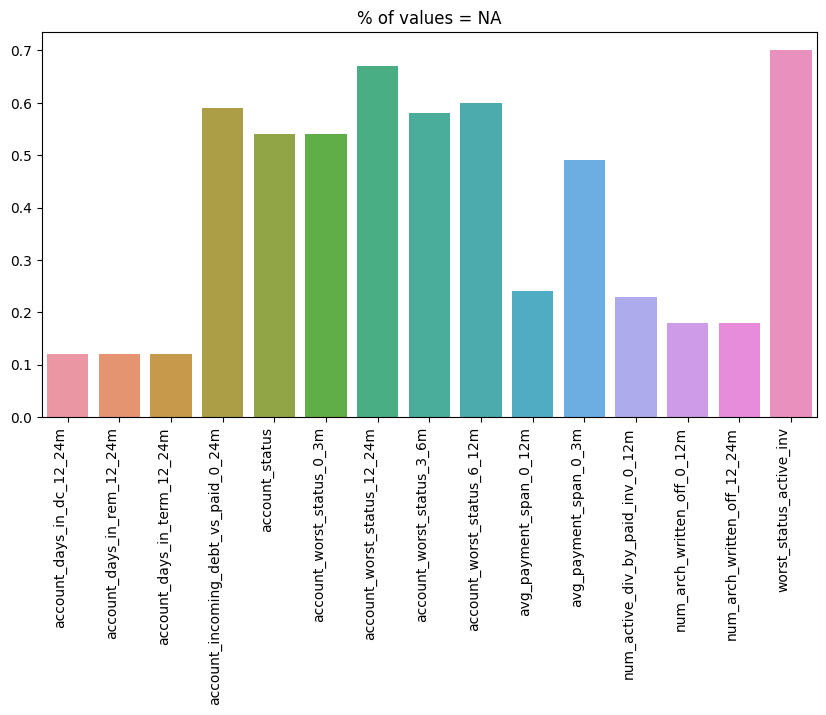

In [6]:
# Explore the dataset, in particular look at the NA counts
has_na = []
for col in df.columns:
    perc_na = 0
    perc_na = round(df[col].isna().sum()/len(df), 2)
    if perc_na > 0:
        has_na.append([col, perc_na])


# Plot out the columns with NA (their percentages)
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
na_plot = sns.barplot(x=[n[0] for n in has_na], y=[n[1] for n in has_na],  ax=ax)
na_plot.set_xticklabels(na_plot.get_xticklabels(), rotation=90, horizontalalignment='right')
na_plot.set_title("% of values = NA");


In [7]:
## Let's explore some of the columns (other than default)
## Look in particular at the columns with high NA.
## Do we need those columns or can we simply drop them?

In [8]:
## Make a copy of the dataframe without columns that have high % NA
# % NA threshhold for columns to keep
na_threshold = .5
# cols_to_keep = [col[0] for col in has_na if col[1] < na_threshold]
# new_df = df[cols_to_keep].copy()

df.drop(columns=[col[0] for col in has_na if col[1] > na_threshold], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89976 entries, 0 to 89975
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uuid                              89976 non-null  object 
 1   default                           89976 non-null  int32  
 2   account_amount_added_12_24m       89976 non-null  int32  
 3   account_days_in_dc_12_24m         79293 non-null  float64
 4   account_days_in_rem_12_24m        79293 non-null  float64
 5   account_days_in_term_12_24m       79293 non-null  float64
 6   age                               89976 non-null  int32  
 7   avg_payment_span_0_12m            68508 non-null  float64
 8   avg_payment_span_0_3m             45594 non-null  float64
 9   merchant_category                 89976 non-null  object 
 10  merchant_group                    89976 non-null  object 
 11  has_paid                          89976 non-null  bool   
 12  max_

In [9]:
## We can see that 'merchant_category', 'merchant_group'
## and 'name_in_email' are categorical (object = string)
## These will either need to be ignored (not a good idea)
## or encoded.

In [10]:
# Have a look at the two 'merchant_' columns
for c in df.columns:
    if(c[:8] == 'merchant'):
            print(df[c].value_counts())
df.info()

Diversified entertainment                                  34781
Youthful Shoes & Clothing                                  10524
Books & Magazines                                           8447
General Shoes & Clothing                                    4162
Concept stores & Miscellaneous                              3969
Sports gear & Outdoor                                       3356
Dietary supplements                                         2777
Diversified children products                               2691
Diversified electronics                                     1627
Prints & Photos                                             1502
Children Clothes & Nurturing products                       1357
Pet supplies                                                1185
Electronic equipment & Related accessories                   946
Hobby articles                                               817
Jewelry & Watches                                            815
Prescription optics      

## Look for correlations

In [11]:
def corr_matrix(df):
    correlation_matrix = df.corr()
    column_names = correlation_matrix.columns

    # Convert the correlation matrix into a DataFrame
    corr_df = correlation_matrix.stack().reset_index()

    # Rename the columns
    corr_df.columns = ['feature_1','feature_2', 'correlation']

    # Remove "self correlations"
    no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
    corr_df = corr_df[no_self_correlation]

    # Absolute correlation
    corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

    # Correlation by pairs of features
    return corr_df.sort_values(by="absolute_correlation", ascending=False)

corr_matrix(df)

,feature_1,feature_2,correlation,absolute_correlation
298,max_paid_inv_0_12m,max_paid_inv_0_24m,0.889912,0.889912
329,max_paid_inv_0_24m,max_paid_inv_0_12m,0.889912,0.889912
496,num_arch_ok_0_12m,num_arch_ok_12_24m,0.864148,0.864148
527,num_arch_ok_12_24m,num_arch_ok_0_12m,0.864148,0.864148
857,status_max_archived_0_24_months,status_max_archived_0_12_months,0.842982,0.842982
...,...,...,...,...
595,num_arch_written_off_0_12m,num_arch_written_off_12_24m,-0.000111,0.000111
211,avg_payment_span_0_12m,num_arch_written_off_12_24m,-0.000088,0.000088
614,num_arch_written_off_12_24m,avg_payment_span_0_12m,-0.000088,0.000088
993,time_hours,account_amount_added_12_24m,-0.000061,0.000061


In [12]:
## There are already 36 columns in the original dataset. A bit less after we
## removed the high percentage NA columns. Before getting into the pipeline
## let's remove some columns that are probably not needed.

## First, columns that are highly correlated (corr > .8)
df.drop(columns=['max_paid_inv_0_24m', 'num_arch_ok_12_24m', 'status_max_archived_0_24_months'], inplace=True)

## Next, categorical columns that 'probably' don't add much value
## We still have the 'merchant_group' column that should be usefule
df.drop(columns=['merchant_category', 'name_in_email'], inplace=True)

## Pipeline

In [13]:
# Defining the features and the target
X = df.drop(columns='default')
y = df['default']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71980, 30), (17996, 30), (71980,), (17996,))

In [14]:
# Build the pipeline with the different steps
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('standard_scaler', StandardScaler())
])

In [15]:
pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standard_scaler', StandardScaler())])

In [16]:
# pipeline.fit(X_train[['age']])
# pipeline.transform(X_train[['age']])

In [18]:
# Impute then scale numerical values:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('standard_scaler', StandardScaler())
])

# Encode categorical values
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Parallelize "num_transformer" and "cat_transfomer"
numeric_cols = X.select_dtypes(include='number').describe().columns.to_list()

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, numeric_cols),
    # ('cat_transformer', cat_transformer, ['merchant_category', 'merchant_group', 'name_in_email'])
    ('cat_transformer', cat_transformer, ['merchant_group']),
] )

In [19]:
preprocessor

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 ['account_amount_added_12_24m',
                                  'account_days_in_dc_12_24m',
                                  'account_days_in_rem_12_24m',
                                  'account_days_in_term_12_24m', 'age',
                                  'avg_payment_span_0_12m',
                                  'avg_payment_span_0_3m', 'max_paid_inv_0_12m',
                                  'num_active_div_by_pai...
                                  'status_last_archived_0_24m',
                                  'status_2nd_last_archived_0_24m',
                                  'status_3rd_last_archived_0_24m',
                                  'status_max_archived_0_6_months',
                                  'status_max_archived_0_12_months',
                                  'recovery_debt',
                                  'sum_capital_paid_account_0_12m',
                                  'sum_capital_paid_account_12_24m',
                                  'sum_paid_inv_0_12m', 'time_hours']),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['merchant_group'])])

In [20]:
X_train_transformed = preprocessor.fit_transform(X_train)

print("Original training set")
display(X_train.head(3))

print("Preprocessed training set")
display(pd.DataFrame(X_train_transformed).head(3))

Original training set


,uuid,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_group,has_paid,...,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
68735,9e853f1a-001e-4378-a77f-17d908963914,0,0.0,0.0,0.0,50,10.714286,8.75,Entertainment,True,...,1,1,1,1,1,0,0,0,52846,17.838333
84101,a7a93442-ac2f-48a9-af80-ac58cc6049d2,0,0.0,0.0,0.0,32,12.000000,5.00,Entertainment,True,...,1,1,1,1,1,0,0,0,9085,18.453611
42395,513b275f-3b2f-469c-a7c0-1c61adf2855d,0,NaN,NaN,NaN,19,NaN,NaN,Clothing & Shoes,False,...,0,0,0,0,0,0,0,0,0,13.465278


Preprocessed training set


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,1.075048,-6.527626e-01,-0.850611,0.373546,-4.436574e-01,-0.386387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,-0.309352,-5.372090e-01,-1.364614,-0.331186,-4.436574e-01,-0.386387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.349225,4.964888e-18,-4.104548e-17,0.000000,-1.309197,3.193003e-16,0.000000,-0.678035,1.072504e-16,-0.386387,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out()
)

transformed_df

,num_transformer__account_amount_added_12_24m,num_transformer__account_days_in_dc_12_24m,num_transformer__account_days_in_rem_12_24m,num_transformer__account_days_in_term_12_24m,num_transformer__age,num_transformer__avg_payment_span_0_12m,num_transformer__avg_payment_span_0_3m,num_transformer__max_paid_inv_0_12m,num_transformer__num_active_div_by_paid_inv_0_12m,num_transformer__num_active_inv,...,cat_transformer__merchant_group_Clothing & Shoes,cat_transformer__merchant_group_Electronics,cat_transformer__merchant_group_Entertainment,cat_transformer__merchant_group_Erotic Materials,cat_transformer__merchant_group_Food & Beverage,cat_transformer__merchant_group_Health & Beauty,cat_transformer__merchant_group_Home & Garden,cat_transformer__merchant_group_Intangible products,cat_transformer__merchant_group_Jewelry & Accessories,"cat_transformer__merchant_group_Leisure, Sport & Hobby"
0,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,1.075048,-6.527626e-01,-0.850611,0.373546,-4.436574e-01,-0.386387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,-0.309352,-5.372090e-01,-1.364614,-0.331186,-4.436574e-01,-0.386387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.349225,4.964888e-18,-4.104548e-17,0.000000,-1.309197,3.193003e-16,0.000000,-0.678035,1.072504e-16,-0.386387,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,0.152115,-6.031173e-01,-0.268074,1.548711,-1.860504e-01,0.260693,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,-0.847730,-9.727572e-01,-1.693576,0.932623,-1.676499e-01,0.260693,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71975,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,-0.232441,3.057793e+00,0.000000,-0.229007,1.488395e+00,0.260693,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71976,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,-0.386263,3.193003e-16,0.000000,-0.678035,1.072504e-16,-0.386387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71977,1.862421,-4.123964e-02,-2.363303e-01,-0.105292,0.459759,7.509999e-01,0.000000,-0.159343,2.454421e+00,1.554852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
71978,-0.349225,-4.123964e-02,-2.363303e-01,-0.105292,0.613582,3.193003e-16,0.000000,-0.678035,1.072504e-16,-0.386387,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
#The reality is that the scaling/encoding should not change the correlations
corr_matrix(transformed_df)

,feature_1,feature_2,correlation,absolute_correlation
801,num_transformer__status_max_archived_0_6_months,num_transformer__status_max_archived_0_12_months,0.734877,0.734877
839,num_transformer__status_max_archived_0_12_months,num_transformer__status_max_archived_0_6_months,0.734877,0.734877
24,num_transformer__account_amount_added_12_24m,num_transformer__sum_capital_paid_account_12_24m,0.712533,0.712533
936,num_transformer__sum_capital_paid_account_12_24m,num_transformer__account_amount_added_12_24m,0.712533,0.712533
721,num_transformer__status_2nd_last_archived_0_24m,num_transformer__status_3rd_last_archived_0_24m,0.694300,0.694300
...,...,...,...,...
462,num_transformer__num_arch_dc_12_24m,cat_transformer__merchant_group_Food & Beverage,0.000067,0.000067
15,num_transformer__account_amount_added_12_24m,num_transformer__num_arch_written_off_12_24m,0.000039,0.000039
585,num_transformer__num_arch_written_off_12_24m,num_transformer__account_amount_added_12_24m,0.000039,0.000039
1329,cat_transformer__merchant_group_Health & Beauty,num_transformer__account_days_in_term_12_24m,-0.000031,0.000031


In [23]:
# Add estimator
pipeline = make_pipeline(preprocessor, Ridge())
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['account_amount_added_12_24m',
                                                   'account_days_in_dc_12_24m',
                                                   'account_days_in_rem_12_24m',
                                                   'account_days_in_term_12_24m',
                                                   'age',
                                                   'avg_payment_span_0_12m',
                                                   'avg_payment_span_0_3m',
                                                   'max_p...
                                                   'status_2nd_last_archived_0_24m',
                                                   'status_3rd_last_archived_0_24m',
                                                   'status_max_archived_0_6_months',
                                                   'status_max_archived_0_12_months',
                                                   'recovery_debt',
                                                   'sum_capital_paid_account_0_12m',
                                                   'sum_capital_paid_account_12_24m',
                                                   'sum_paid_inv_0_12m',
                                                   'time_hours']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant_group'])])),
                ('ridge', Ridge())])

In [24]:
# Train Pipeline
pipeline.fit(X_train,y_train)

# Make predictions
pipeline.predict(X_test.iloc[0:1])

# Score model
pipeline.score(X_test,y_test)

0.038843248013721965